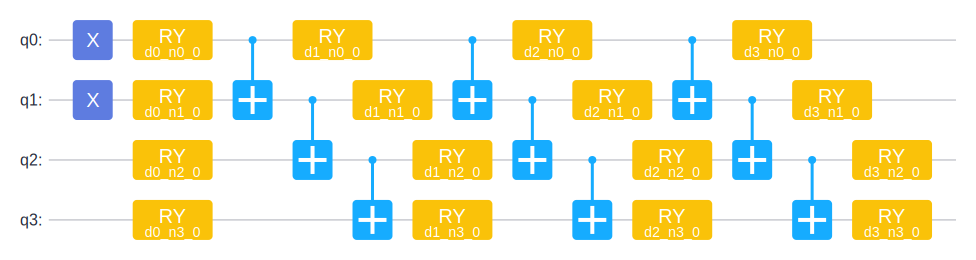

/home/ma-user/anaconda3/envs/Mindquantum-0.9.0/lib/python3.9/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


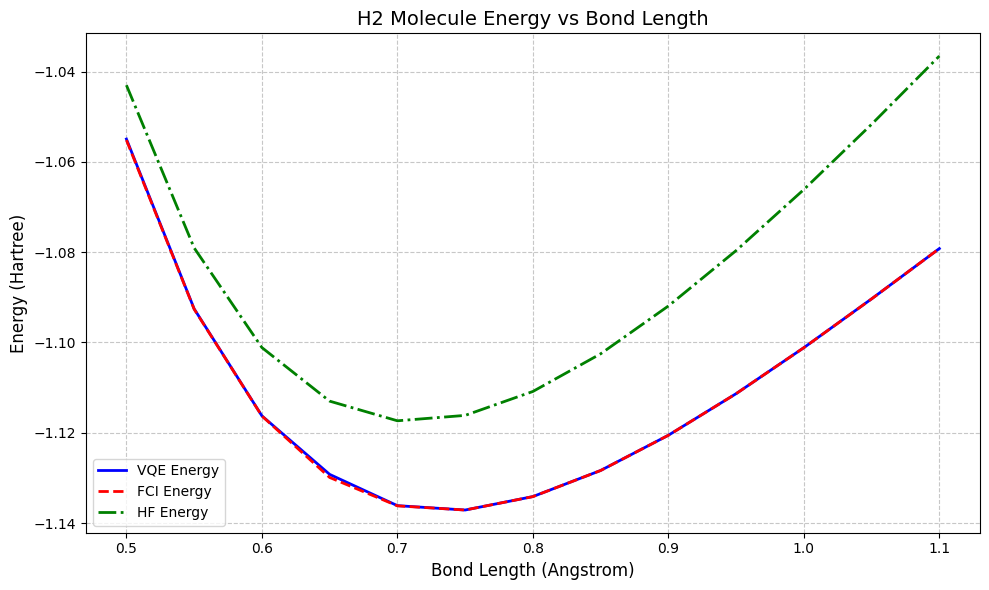

In [4]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from mindquantum.core.operators import Hamiltonian
from mindquantum.algorithm import get_qubit_hamiltonian, HardwareEfficientAnsatz
from mindquantum.core.gates import X, H, RY, BarrierGate
from mindquantum.core.circuit import Circuit, UN
from mindquantum.simulator import Simulator
from mindquantum.framework import MQAnsatzOnlyLayer
import mindspore.nn as nn
from matplotlib import pyplot as plt
from IPython.display import display_svg


def get_H2_ham(d):
    """
    根据键长生成H2分子哈密顿量
    Args:
        d (float): 键长，单位埃米
    Returns:
        Hamiltonian: H2分子哈密顿量
    """
    mol = MolecularData([("H", (0, 0, 0)), ("H", (0, 0, d))], "sto3g", multiplicity=1)
    mol = run_pyscf(mol, run_fci=1)
    return Hamiltonian(get_qubit_hamiltonian(mol)), mol.fci_energy, mol.hf_energy


# TODO: 请根据图中所示构建量子线路
circ = Circuit()
# 在这里添加量子门...
circ = UN(X, 2) +BarrierGate(False) + HardwareEfficientAnsatz(4, single_rot_gate_seq=[RY], entangle_gate=X, depth=3).circuit # 通过HardwareEfficientAnsatz搭建Ansatz

#circ = (UN(X, 2) + BarrierGate(False) + (RY(f'a{i}').on(i) for i in range(4)) + (X.on(i+1, i) for i in range(3)) + BarrierGate(False)
        #+ (RY(f'b{i}').on(i) for i in range(4)))   #依次添加2个X门、4个RY门、4个CNOT门和4个RY门，相当于Hartree-Fork + HardwareEfficientAnsatz(depth=1)的情况

#circ = UN(X, 2) + BarrierGate()+(RY(f'a{i}').on(i) for i in range(4))   #只有Hartree-Fork、没有HardwareEfficientAnsatz的情况，最终结果肯定和hf_energies一致
display_svg(circ.svg())

# Initialize lists to store results
distances = [i/20 for i in range(10, 23)]  # From 0.5 to 1.1 Angstrom with 0.05 step
energies = []
fci_energies = []
hf_energies = []

# Create simulator
sim = Simulator('mqvector', 4)

for d in distances:
    # Calculate Hamiltonian for current distance
    ham, fci_energy, hf_energy = get_H2_ham(d)

    fci_energies.append(fci_energy)
    hf_energies.append(hf_energy)

    
    # TODO: 获取期望值和梯度算子
    grad_ops = sim.get_expectation_with_grad(ham, circ) #调用get_expectation_with_grad接口生成计算期望值和梯度的算子，通过不断更新参数来不断产生期望值和梯度

    # TODO: 生成待训练的神经网络
    net = MQAnsatzOnlyLayer(grad_ops)  #使用MQAnsatzOnlyLayer作为待训练的量子神经网络
    # TODO: 设置优化器
    opti = nn.Adam(net.trainable_params(), learning_rate=0.06)  # 设置针对网络中所有可训练参数、学习率为0.06的Adam优化器
    # TODO: 生成能对神经网络进行一步训练的算子
    train_net = nn.TrainOneStepCell(net, opti)  #把神经网络net和优化器opti传入到训练的算子TrainOneStepCell中

    # 对网络进行200步训练
    for i in range(200):
        train_net()

    # 获取第201步训练后的网络的输出，并将其添加到energies列表中
    energies.append(train_net().asnumpy())
    

# Plot results
plt.figure(figsize=(10, 6))
if energies:
    plt.plot(distances, energies, 'b-', label='VQE Energy', linewidth=2)
plt.plot(distances, fci_energies, 'r--', label='FCI Energy', linewidth=2)
plt.plot(distances, hf_energies, 'g-.', label='HF Energy', linewidth=2)
plt.xlabel('Bond Length (Angstrom)', fontsize=12)
plt.ylabel('Energy (Hartree)', fontsize=12)
plt.title('H2 Molecule Energy vs Bond Length', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()